In [2]:
ppo_list =  [
    "/home/lorenzo/Desktop/drl-cong/log/ppo/iperf/att.lte.driving.2016/att.lte.driving.2016.2023.05.28.00.45.20.json",
    "/home/lorenzo/Desktop/drl-cong/log/ppo/iperf/tm.lte.driving/tm.lte.driving.2023.05.28.00.47.00.json",
    "/home/lorenzo/Desktop/drl-cong/log/ppo/iperf/vz.lte.driving/vz.lte.driving.2023.05.28.00.48.16.json"
]

# mutant_list = [
#     "/home/lorenzo/mimic-2/log/iperf/4_arms/att.lte.driving.2016.epsilon_greedy_decay.2023.07.25.07.13.51.json",
#     "/home/lorenzo/mimic-2/log/iperf/4_arms/tm.lte.driving.epsilon_greedy_decay.2023.07.25.07.24.18.json",
#     "/home/lorenzo/mimic-2/log/iperf/4_arms/vz.lte.driving.epsilon_greedy_decay.2023.07.25.07.42.48.json"
# ]

mutant_list = [
    "/home/lorenzo/mimic-2/log/iperf/att.lte.driving.2016.epsilon_greedy_decay.2023.07.31.17.10.44.json",
    "/home/lorenzo/mimic-2/log/iperf/tm.lte.driving.epsilon_greedy_decay.2023.07.31.17.11.48.json",
    "/home/lorenzo/mimic-2/log/iperf/vz.lte.driving.epsilon_greedy_decay.2023.07.31.17.12.53.json"
]

mutant_history_list = [
    "/home/lorenzo/mimic-2/log/mab/history/epsilon_greedy_decay.2023.07.25.08.01.19.2023.07.25.18.44.08.json",
    "/home/lorenzo/mimic-2/log/mab/history/epsilon_greedy_decay.2023.07.25.08.01.19.2023.07.25.18.45.20.json",
    "/home/lorenzo/mimic-2/log/mab/history/epsilon_greedy_decay.2023.07.25.08.01.19.2023.07.25.18.46.27.json"
]

ppo_history_list = [
    "/home/lorenzo/Desktop/drl-cong/log/ppo/obs/att.lte.driving.2016.2023.05.28.00.45.20.npy",
    "/home/lorenzo/Desktop/drl-cong/log/ppo/obs/tm.lte.driving.2023.05.28.00.47.00.npy",
    "/home/lorenzo/Desktop/drl-cong/log/ppo/obs/vz.lte.driving.2023.05.28.00.48.16.npy"

]

In [3]:
ppo_json = {}
mutant_json = {}
ppo_json_hist = {}
mutant_json_hist = {}

traces = ["att.lte.driving.2016", "tm.lte.driving", "vz.lte.driving"]
for t in traces:
    for file in ppo_list:
        if t in file:
            ppo_json[t] = file
    for file in mutant_list:
        if t in file:
            mutant_json[t] = file

for t in traces:
    for file in ppo_history_list:
        if t in file:
            ppo_json_hist[t] = file
    for file in mutant_history_list:
        mutant_json_hist[t] = file


In [4]:
import numpy as np

def get_metrics(config):
    rtts = []
    cwnds = [] 
    s_rate = []
    for intervals in config['intervals']:
        s_rate.append(intervals['streams'][0]['bits_per_second']*10**(-6))
        cwnds.append(intervals['streams'][0]['snd_cwnd'])
        rtts.append(intervals['streams'][0]['rtt']*10**(-3))
    thruput = config["end"]["streams"][0]["receiver"]["bits_per_second"]*10**(-6)
    return thruput, rtts, cwnds, s_rate

# cwnd, rtt, rtt_dev, delivered, delivered_diff, loss_rate, in_flight, retrans
# Get thr observations
def get_features(feature_vector):
    cwnd_values = []
    rtt_values = []
    thr_values = []
    for step in feature_vector.keys():
        for batch in feature_vector[step]:
            cwnd_values.append(batch[0])
            rtt_values.append(batch[1])
            thr_values.append(batch[8])
    return cwnd_values, rtt_values, thr_values

def get_features_ppo(feature_vector):
    cwnd_values = []
    rtt_values = []
    thr_values = []
    for step in feature_vector:
        for batch in step:
            cwnd_values.append(batch[0])
            rtt_values.append(batch[1])
            thr_values.append(batch[8])
    return cwnd_values, rtt_values, thr_values

def build_features_per_step(json_obj):
    step_array = {}
    for i, step_logs in enumerate(json_obj):
        step_array[i] = []
        for features_vector in step_logs["observation"]["features"]:
            step_array[i].append(features_vector)
    return step_array
import json

def cdf(x):
    N = len(x)

    # sort the data in ascending order
    x = np.sort(x)
    
    # get the cdf values of y
    y = np.arange(N) / float(N)

    return (x, y)
def get_timestamp(string):
    # Extract the timestamp from the string
    start_index = string.rfind('.') - 19
    end_index = string.rfind('.')
    timestamp = string[start_index:end_index]
    return timestamp


In [5]:
import numpy as np

ppo_metrics = {}
mutant_metrics = {}

for t, file in ppo_json.items():
    json_obj = []
    with open (ppo_json[t], 'r') as f:
        json_obj = json.load(f)
    thruput, rtts, cwnds, s_rate = get_metrics(json_obj)
    ppo_metrics[t] = (rtts, thruput, s_rate)

for t, file in mutant_json.items():
    json_obj = []
    with open (mutant_json[t], 'r') as f:
        json_obj = json.load(f)
    thruput, rtts, cwnds, s_rate = get_metrics(json_obj)
    mutant_metrics[t] = (rtts, thruput, s_rate)

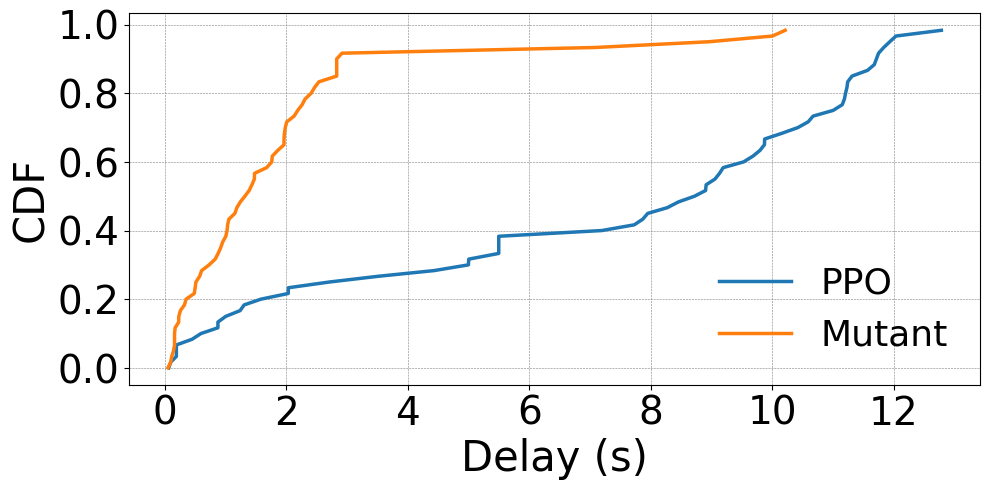

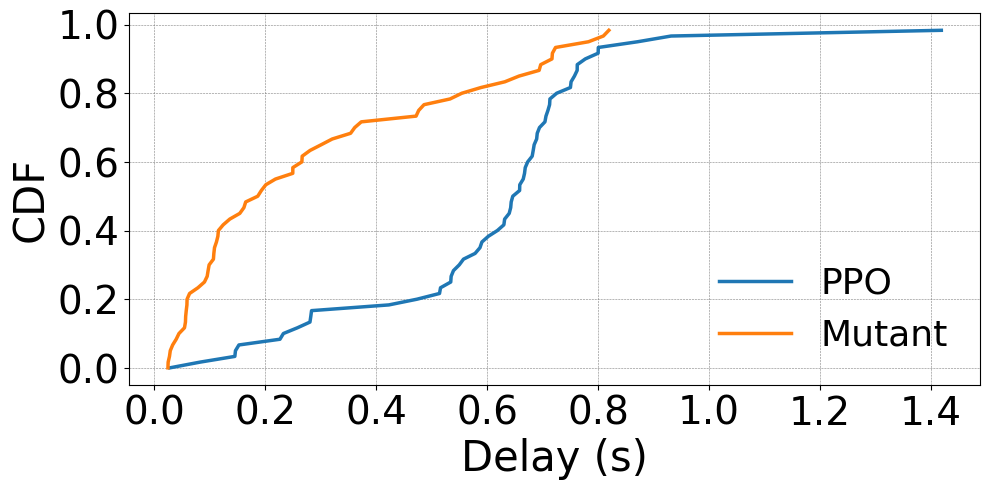

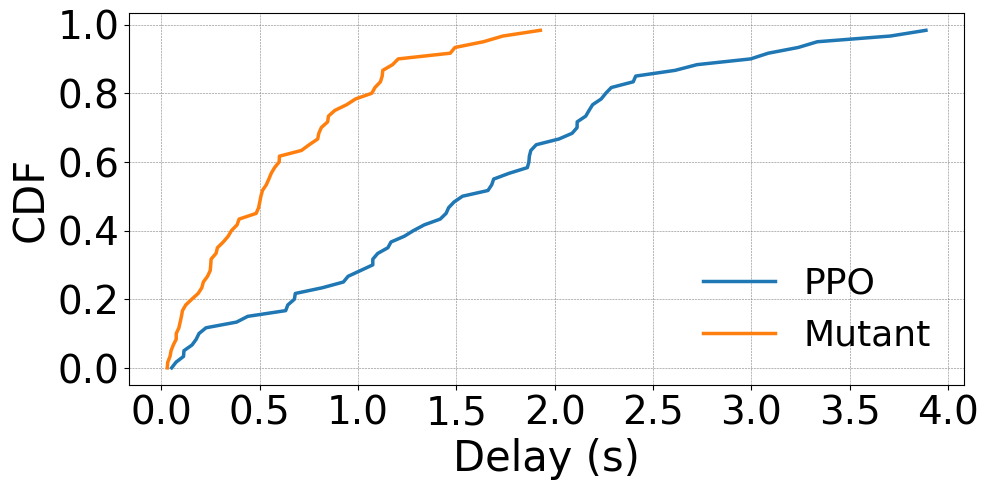

In [10]:

import matplotlib.pyplot as plt
import os

markers = ['o', '^', 's', 'd', 'v', '*']

# List of line styles
line_styles = ['-', '--', ':', '-.', '.', '']


for t, metrics in ppo_metrics.items():
    plt.figure(figsize=(10,5))
    

    ppo_rtts = ppo_metrics[t][0]
    # thrs = arr[1]
    ppo_t_x, ppo_t_y = cdf(ppo_rtts)
    plt.plot(ppo_t_x/1000, ppo_t_y, label="PPO", linewidth=2.5)
    
    mutant_rtts = mutant_metrics[t][0]
    # thrs = arr[1]
    mutant_t_x, mutant_t_y = cdf(mutant_rtts)
    plt.plot(mutant_t_x/1000, mutant_t_y, label="Mutant", linewidth=2.5)


    plt.legend(fontsize=26, frameon=False)
    # plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.xlabel("Delay (s)", fontsize=30)
    plt.ylabel("CDF", fontsize=30)

    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.grid(linestyle='--', linewidth=0.4, color="grey")
    plt.tight_layout()
    path = "/home/lorenzo/Desktop/drl-cong/analysis/plots"
    plt.savefig(os.path.join(path, f"{t}_ppo_vs_mutant_delay.png"))
    plt.show()

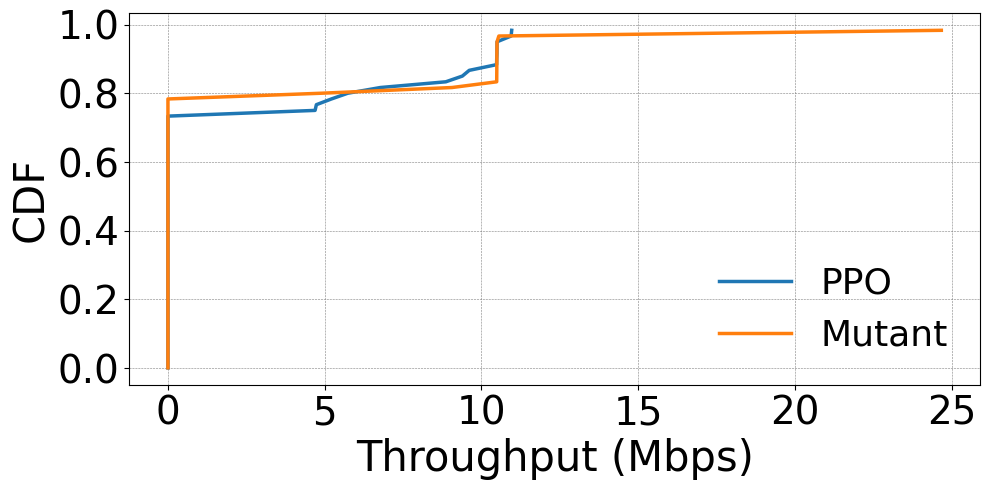

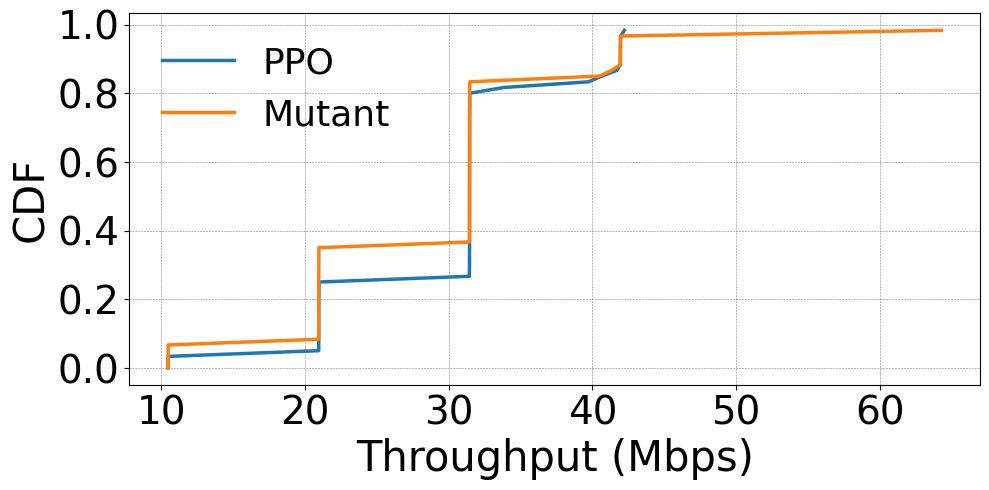

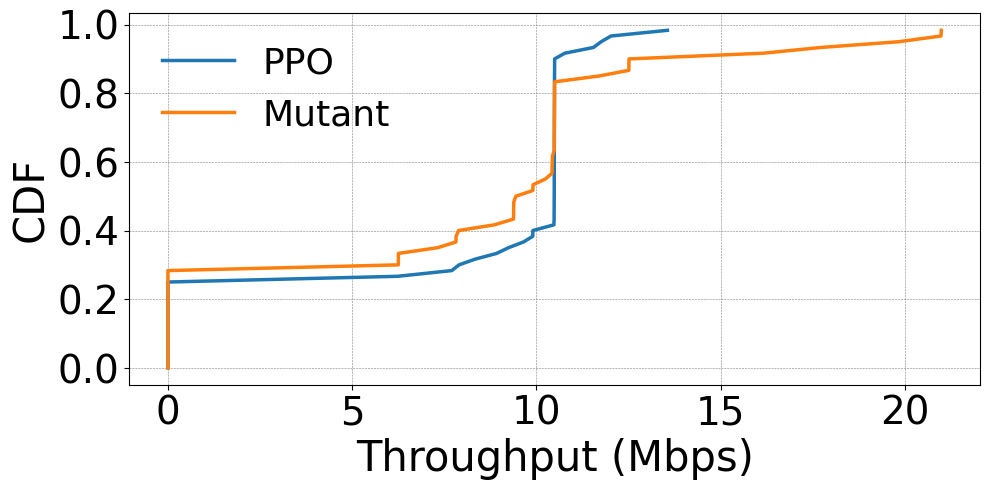

In [11]:

import matplotlib.pyplot as plt
import os

for t, metrics in ppo_metrics.items():
    plt.figure(figsize=(10,5))
    

    ppo_rtts = ppo_metrics[t][2]
    # thrs = arr[1]
    ppo_t_x, ppo_t_y = cdf(ppo_rtts)
    plt.plot(ppo_t_x, ppo_t_y, label="PPO", linewidth=2.5)
    
    mutant_rtts = mutant_metrics[t][2]
    # thrs = arr[1]
    mutant_t_x, mutant_t_y = cdf(mutant_rtts)
    plt.plot(mutant_t_x, mutant_t_y, label="Mutant", linewidth=2.5)


    plt.legend(fontsize=26, frameon=False)
    # plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.xlabel("Throughput (Mbps)", fontsize=30)
    plt.ylabel("CDF", fontsize=30)

    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.grid(linestyle='--', linewidth=0.4, color="grey")
    plt.tight_layout()
    path = "/home/lorenzo/Desktop/drl-cong/analysis/plots"
    plt.savefig(os.path.join(path, f"{t}_ppo_vs_mutant_thru.png"))
    plt.show()

THROUGHPUT FROM HISTORY

In [8]:
import numpy as np

ppo_metrics_hist = {}
mutant_metrics_hist = {}

for t, file in mutant_json_hist.items():
    json_obj = []
    with open (file, 'r') as f:
        for line in f:
            json_obj.append(json.loads(line))
   
    s_arr_p = build_features_per_step(json_obj)
    cwnd_values, rtt_values, thr_values = get_features(s_arr_p)
    mutant_metrics_hist[t] = thr_values

for t, file in ppo_json_hist.items():
    json_obj = []
    thruputs = np.load(file, allow_pickle=True)
    cwnd_values, rtt_values, thr_values = get_features_ppo(thruputs)
    ppo_metrics_hist[t] = thruputs

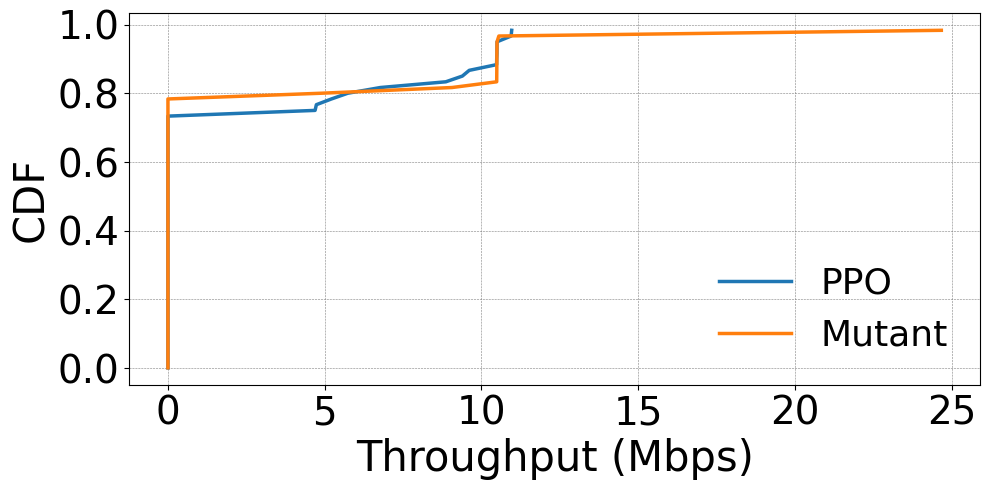

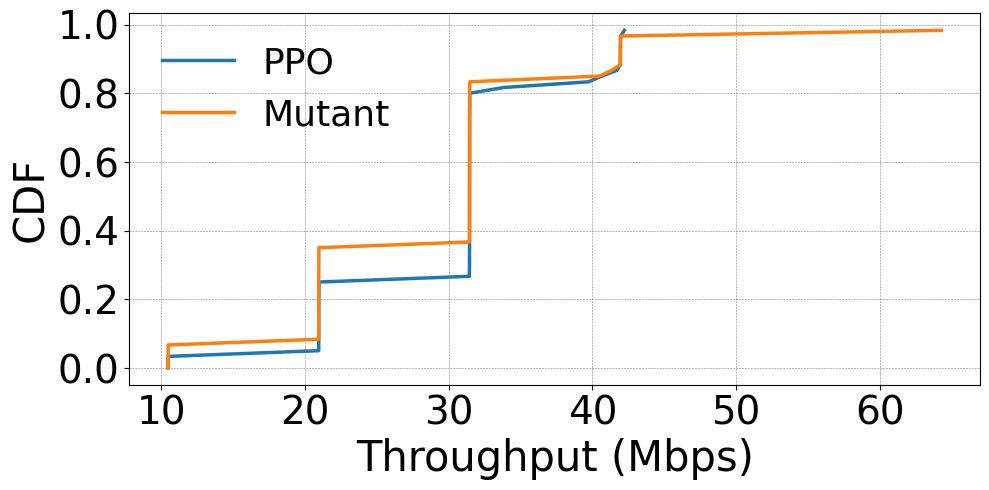

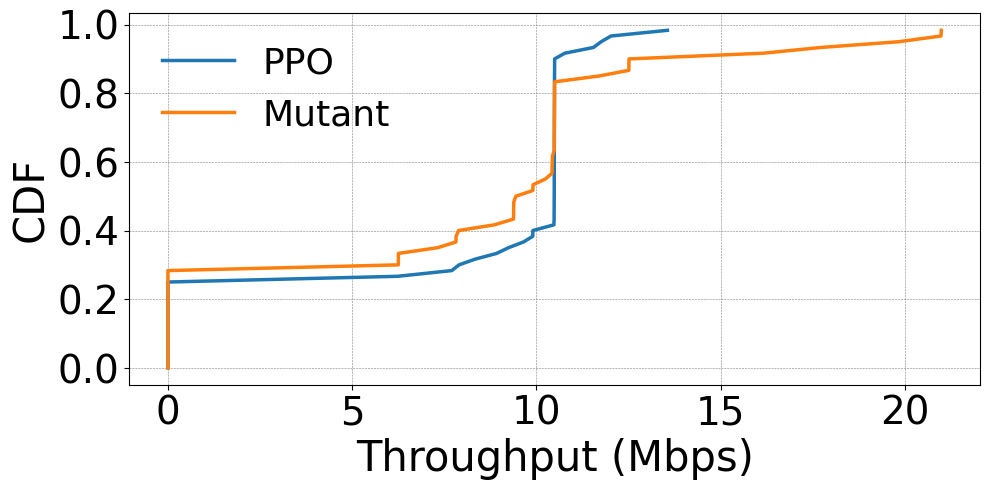

In [9]:
import matplotlib.pyplot as plt
import os

for t, metrics in ppo_metrics.items():
    plt.figure(figsize=(10,5))

    ppo_rtts = ppo_metrics[t][2]
    # thrs = arr[1]
    ppo_t_x, ppo_t_y = cdf(ppo_rtts)
    plt.plot(ppo_t_x, ppo_t_y, label="PPO", linewidth=2.5)
    
    mutant_rtts = mutant_metrics[t][2]
    # thrs = arr[1]
    mutant_t_x, mutant_t_y = cdf(mutant_rtts)
    plt.plot(mutant_t_x, mutant_t_y, label="Mutant", linewidth=2.5)


    plt.legend(fontsize=26, frameon=False)
    # plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.xlabel("Throughput (Mbps)", fontsize=30)
    plt.ylabel("CDF", fontsize=30)

    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.grid(linestyle='--', linewidth=0.4, color="grey")
    plt.tight_layout()
    path = "/home/lorenzo/mimic-2/analysis/plots/top_k"
    # plt.savefig(os.path.join(path, f"{trace}_top_k_delay.png"))
    plt.show()